In [1]:
import os
import PIL
from PIL import Image
import numpy as np
import json
import torch
from torch.utils.data import Dataset, DataLoader
import itertools
from torchvision import datasets, transforms, models
from custom_transform import ThresholdTransform,AddNoise,DetachWhite
from einops import rearrange

/data/jong980812/anaconda3/envs/asd/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Image Open

# Model


In [ ]:
import torchvision.models as models
model=models.efficientnet_b1(pretrained=True,progress=False)
model.classifier[1] = torch.nn.Linear(1280, 2)
import torchvision
# model=torchvision.models.resnet18()
# in_feat=model.fc.in_features
# model.fc=torch.nn.Linear(in_feat,2)
data_path='/data/datasets/asd/All_5split/01/val/TD/'
# data_path='/data/datasets/ai_hub_sketch_4way/01/val/m_w'
# data_path='/data/datasets/ai_hub/ai_hub_sketch_mw/01/val/w/'
import random
weight='/data/jong980812/project/mae/result_ver2/All_5split/binary_240/OUT/01/checkpoint-29.pth'
checkpoint = torch.load(weight, map_location='cpu')
print("Load pre-trained checkpoint from: %s" % weight)
checkpoint_model = checkpoint['model']
state_dict = model.state_dict()
msg = model.load_state_dict(checkpoint_model, strict=False)
model.eval()
print(msg)

# Json Open

# Function


In [ ]:
def replace_part(img,image_path,replace_img,part,is_black=False):
    json_path='/data/datasets/asd/asd_all_5folds_annotations'
    json_name = image_path.split('/')[-1].split('.')[0] + ".json"
    part_json = {}
    with open(os.path.join(json_path, json_name), 'r') as f :   
        boxes=json.load(f)['shapes']
        for box in boxes:
            part_json[box["label"]]=box["points"]
    #! 0: 사람 전체 1: 머리 2:얼굴 3:눈 4:눈
        
    part_anns = part_json[part]
    
    coords = [int(part_anns[0][0]), int(part_anns[0][1]), int(part_anns[1][0]), int(part_anns[1][1])]
    xmin, ymin, xmax, ymax = coords
    # xmin, ymin = int(x), int(y)
    # xmax, ymax = int(x + w), int(y + h)
    # print(coords)
    box_region = img.crop(coords)
    black_box = 255*np.ones(box_region.size)
    black_box = Image.fromarray(black_box)
    if box_region.size != replace_img.size:
        replace_img= replace_img.resize(box_region.size)
        black_box = black_box.resize(box_region.size)
        print('replace_part is resized')
    
    if is_black:
        img.paste(black_box,coords)
    else:
        img.paste(replace_img,coords)
    # return sample_img

In [ ]:
class shapley_part(Dataset):
    def __init__(self, data_folder, json_folder, binary_thresholding=None, transform=None):
        self.json_folder = json_folder
        self.data_folder = data_folder
        self.binary_thresholding=binary_thresholding
        self.transform = transform
        self.image_paths = [os.path.join(data_folder, f) for f in os.listdir(data_folder) if f.endswith(('.png', '.jpg', '.jpeg', '.gif'))]
        self.json_paths = [image_path.split('/')[-1].split('.')[0] + ".json" for image_path in self.image_paths] #! Get json path from image paths.
        print(self.image_paths)
    def get_part_json(self, json_file_path, part_name):
        '''
        Get part dictionary from json path
        '''
        part_json = {}
        
        for part in part_name:
            part_json[part] = []
        with open(json_file_path, 'r') as f:
            boxes = json.load(f)['shapes']
            for box in boxes:
                part_json[box["label"]].append(box["points"])
    
        for key in part_json:#! 빈 애들은 None으로 처리해서 없다고 판단.
            if not part_json[key]:
                part_json[key] = None

        return part_json
    def get_coords(self, part):
        extracted_coordinates = []
        if part is None:
            return None
        elif len(part) == 1:
            # print(part[0][0])
            xmin, ymin = list(map(int,part[0][0]))
            xmax, ymax = list(map(int,part[0][1]))
            return [[xmin,ymin,xmax,ymax]]#아래 2일경우와 통일하기 위해 이중 리스트로 
        elif len(part) == 2:
            #! Eye, Ear, hand, foot -> These have 2 part, return list
            for a in part: 
                # print(a)
                xmin, ymin = list(map(int,a[0]))
                xmax, ymax = list(map(int,a[1]))
                extracted_coordinates.append([xmin,ymin,xmax,ymax])
            return extracted_coordinates
        else:
            exit(0)
    def get_white_image(self,size):
        return Image.new("RGB", size, (255, 255, 255))
    def get_empty_face(self,img, part_imgs, part_json):
        '''
        empty_face is face detached 'eye','nose','mouth','ear'
        '''
        head_json = part_json['head']
        head_coords = self.get_coords(head_json)
        head = part_imgs['head'][0]#!
        white_image = self.get_white_image(img.size)
        white_image.paste(head,head_coords[0])
        for part in ['eye','nose','mouth','ear']:
            if part_json[part] is not None:
              part_coords= self.get_coords(part_json[part])
              part_img = part_imgs[part]
              if part in ['eye','ear']:   
                  white_image.paste(self.get_white_image(part_img[0].size),part_coords[0])
                  white_image.paste(self.get_white_image(part_img[1].size),part_coords[1])
              else:
                  white_image.paste(self.get_white_image(part_img[0].size),part_coords[0])
                  
        return white_image 
    def get_empty_face(self,img, part_imgs, part_json):
        '''
        empty_face is face detached 'eye','nose','mouth','ear'
        '''
        head_json = part_json['head']
        head_coords = self.get_coords(head_json)
        head = part_imgs['head'][0]#!
        white_image = self.get_white_image(img.size)
        white_image.paste(head,head_coords[0])
        for part in ['eye','nose','mouth','ear']:
            if part_json[part] is not None:
              part_coords= self.get_coords(part_json[part])
              part_img = part_imgs[part]
              if part in ['eye','ear']:   
                  white_image.paste(self.get_white_image(part_img[0].size),part_coords[0])
                  white_image.paste(self.get_white_image(part_img[1].size),part_coords[1])
              else:
                  white_image.paste(self.get_white_image(part_img[0].size),part_coords[0])
        # white_image.show()
        return white_image
    def get_empty_lower_body(self,img, part_imgs, part_json):
        '''
        empty_lower_body detacched foot
        '''
        lower_body_json = part_json['lower_body']
        lower_body_coords = self.get_coords(lower_body_json)
        lower_body = part_imgs['lower_body'][0]#!
        white_image = self.get_white_image(img.size)
        white_image.paste(lower_body,lower_body_coords[0])
        if part_json["foot"] is not None:
            part_coords= self.get_coords(part_json["foot"])
            part_img = part_imgs["foot"] 
            white_image.paste(self.get_white_image(part_img[0].size),part_coords[0])
            white_image.paste(self.get_white_image(part_img[1].size),part_coords[1])
        
        return white_image.crop(lower_body_coords[0])
    def get_empty_upper_body(self,img, part_imgs, part_json):
        '''
        empty_lower_body detacched foot
        '''
        upper_body_json = part_json['upper_body']
        upper_body_coords = self.get_coords(upper_body_json)
        upper_body = part_imgs['upper_body'][0]#!
        white_image = self.get_white_image(img.size)
        white_image.paste(upper_body,upper_body_coords[0])
        if part_json["hand"] is not None:
            part_coords= self.get_coords(part_json["hand"])
            part_img = part_imgs["hand"] 
            white_image.paste(self.get_white_image(part_img[0].size),part_coords[0])
            white_image.paste(self.get_white_image(part_img[1].size),part_coords[1])
        # white_image.crop(upper_body_coords[0]).show()
        return white_image.crop(upper_body_coords[0])
    
    def create_new_images(self,img, binary_combination, part_imgs,part_json):
        #! Making New images
        original_img = img
        empty_face_active, eye_active, nose_active, ear_active, mouth_active, hand_active, foot_active = binary_combination
        # New white image

        new_image = self.get_white_image(original_img.size)
        if empty_face_active:
            new_image.paste(part_imgs["empty_face"][0],(0,0))
        # print(part_json['lower_body'][0])
        # print(part_imgs["empty_lower_body"][0].size,self.get_coords(part_json['lower_body'])[0] )
        new_image.paste(part_imgs["empty_lower_body"][0], self.get_coords(part_json['lower_body'])[0])  # 원하는 위치에 붙임
        new_image.paste(part_imgs["empty_upper_body"][0], self.get_coords(part_json['upper_body'])[0])  # 원하는 위치에 붙임
        # 각 파트 이미지를 읽어와서 새로운 이미지에 붙임
        if eye_active and (part_json["eye"] is not None):
            new_image.paste(part_imgs["eye"][0], self.get_coords(part_json['eye'])[0])  # 원하는 위치에 붙임
            new_image.paste(part_imgs["eye"][1], self.get_coords(part_json['eye'])[1])  # 원하는 위치에 붙임 
        if nose_active and (part_json["nose"] is not None):
            new_image.paste(part_imgs["nose"][0], self.get_coords(part_json['nose'])[0])  # 원하는 위치에 붙임 
        if ear_active and (part_json["ear"] is not None):
            new_image.paste(part_imgs["ear"][0], self.get_coords(part_json['ear'])[0])  # 원하는 위치에 붙임 
            new_image.paste(part_imgs["ear"][1], self.get_coords(part_json['ear'])[1])  # 원하는 위치에 붙임 
        if mouth_active and (part_json["mouth"] is not None):
            new_image.paste(part_imgs["mouth"][0], self.get_coords(part_json['mouth'])[0])  # 원하는 위치에 붙임 
        if hand_active and (part_json["hand"] is not None):
            new_image.paste(part_imgs["hand"][0], self.get_coords(part_json['hand'])[0])  # 원하는 위치에 붙임 
            new_image.paste(part_imgs["hand"][1], self.get_coords(part_json['hand'])[1])  # 원하는 위치에 붙임 
        if foot_active and (part_json["foot"] is not None):
            new_image.paste(part_imgs["foot"][0], self.get_coords(part_json['foot'])[0])  # 원하는 위치에 붙임 
            new_image.paste(part_imgs["foot"][1], self.get_coords(part_json['foot'])[1])  # 원하는 위치에 붙임 
        # 다른 파트들에 대해서도 같은 방식으로 처리
        return new_image
    def __len__(self):
        return len(self.image_paths)
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        print(img_path)
        label = 0 if (img_path.split('/')[-1].split('.')[0].split('-')[0])=='A' else 1
        image = Image.open(img_path)
        part_name = ["head", "eye", "nose", "ear", "mouth", "hand", "foot", "upper_body", "lower_body"]
        if self.binary_thresholding:
            image = image.convert("L")#! Convert grayscale
            image = image.point(lambda p: p > self.binary_thresholding and 255)
        part_json = self.get_part_json(os.path.join(self.json_folder,self.json_paths[idx]),part_name=part_name)
        part_imgs = {}
        for part in part_name:#모든 part를 다시 dict으로 리턴하기위함.
            part_imgs[part]=[]
            # print(part)
            coords = self.get_coords(part_json[part])
            # print(coords)
            if coords is None:
                part_imgs[part].append(None)    
                
            elif len(coords) ==1:
                part_imgs[part].append(image.crop(coords[0]))    
            elif len(coords) == 2:
                part_imgs[part].append(image.crop(coords[0]))    
                part_imgs[part].append(image.crop(coords[1]))    
        empty_face = self.get_empty_face(image,part_imgs,part_json)
        # empty_face.show()
        empty_upper_body = self.get_empty_upper_body(image,part_imgs,part_json)
        empty_lower_body = self.get_empty_lower_body(image,part_imgs,part_json)
        part_imgs['empty_face']=[empty_face]
        part_imgs['empty_lower_body']=[empty_lower_body]
        part_imgs['empty_upper_body']=[empty_upper_body]
        part_combinations = list(itertools.product([0, 1], repeat=7))
        new_imgs = []
        for combination in part_combinations:
            # print(combination)
            new_img=self.create_new_images(img=image,binary_combination=combination, part_imgs=part_imgs,part_json=part_json)
            if self.transform:
                new_img=self.transform(new_img)
            new_imgs.append(new_img.unsqueeze(0))
        new_imgs = torch.cat(new_imgs,dim=0)
        image = self.transform(image)
        image_3ch = image.expand(3,-1,-1)
        return new_imgs,image_3ch,label 

In [ ]:
# import gc
# gc.collect()

In [ ]:
transform= transforms.Compose([transforms.Resize((224,224)),transforms.ToTensor()])
dataset = shapely_part('/data/jong980812/project/mae/util/shapley','/data/jong980812/project/mae/util/shapley',240,transform=transform)

In [ ]:
dataset[0]

In [ ]:
data_loader=DataLoader(dataset,2,num_workers=8)


In [ ]:
from itertools import product

n = 6  # digit의 개수
digits = [0, 1]  # 각 digit의 가능한 값

# 경우의 수 생성
part_combinations = list(product(digits, repeat=n))

def binary_to_decimal(binary_tuple):
    decimal_value = 0
    binary_length = len(binary_tuple)

    for i, bit in enumerate(binary_tuple):
        decimal_value += bit * (2 ** (binary_length - i - 1))

    return decimal_value
def decimal_to_binary(decimal_value, num_bits):
    binary_tuple = []
    
    for i in range(num_bits):
        bit = (decimal_value >> (num_bits - i - 1)) & 1
        binary_tuple.append(bit)
    
    return tuple(binary_tuple)
def count_ones(binary_tuple):
    count = 0
    for bit in binary_tuple:
        if bit == 1:
            count += 1
    return count
index_to_insert = 1  # 두 번째 위치에 추가하려면 인덱스 1을 사용합니다.
all_ordered_pair=[]
for index in range(7):
    ordered_pair=[] 
    index_to_insert = index
    for combi in part_combinations:
        insert_value = [0,1]
        new_combi_0= combi[:index_to_insert] + (insert_value[0],) + combi[index_to_insert:]
        new_combi_1= combi[:index_to_insert] + (insert_value[1],) + combi[index_to_insert:]
        ordered_pair.append([binary_to_decimal(new_combi_0),binary_to_decimal(new_combi_1)])
    all_ordered_pair.append(ordered_pair)
    

all_ordered_pair=torch.Tensor(all_ordered_pair)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
for new_imgs,label,_ in data_loader:
    print(new_imgs.shape)
    input_data = new_imgs
    print('complete')
    # batch_size = input_data.shape[0]
    # input_data = rearrange(input_data,  'b t c h w -> (b t) c h w')
    
    # model.to(device)
    # input_data.to(device)
    # model.eval()
    # with torch.no_grad():
    #     output=model(input_data)
    # output = rearrange(output, '(b t) o -> b t o', b=batch_size) # batch_size, 128, output(2)
    # print(label)
    # correct_output = output[:,:,label].squeeze(-1)# Take correct logits, and last dimension squeeze (b, 128)


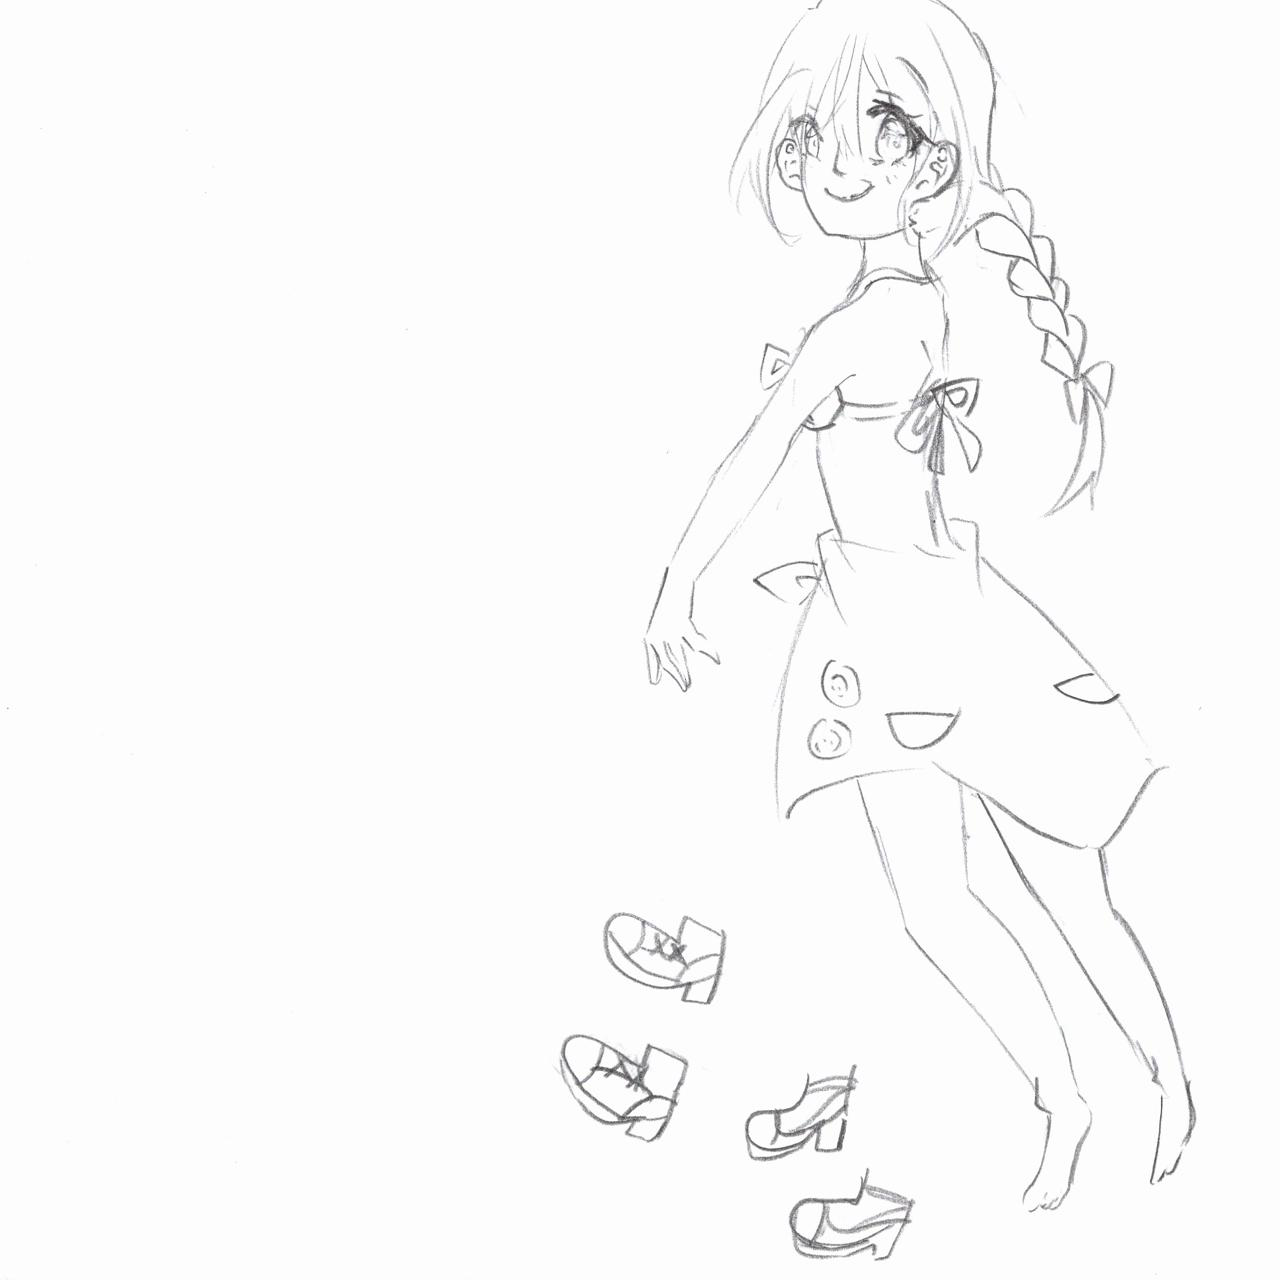

In [38]:
Image.open('/local_datasets/ai_hub_sketch_mw/01/val/w/w_13_m_12149.jpg')

In [36]:
path = '/data/datasets/ai_hub_sketch_json_asd_version/'
path = '/data/datasets/ai_hub_sketch_json_asd_version/'

# 디렉토리 내의 모든 JSON 파일에 대해 반복
for json_file in os.listdir(path):
    if json_file.endswith('.json'):  # JSON 파일인 경우만 처리
        json_file_path = os.path.join(path, json_file)  # 파일 경로 생성

        with open(json_file_path, 'r') as f :   
            boxes=json.load(f)['shapes']
            count=0
            for box in boxes:
                # print(len(box['points']))
                if (box['label']=='arm'):
                    count+=1
            if count==1:
                print(json_file)
                
                

        

w_10_w_04642.json
w_13_m_12149.json


In [ ]:
new_imgs.shape

In [ ]:
shapely_values = torch.zeros_like(all_ordered_pair, dtype=torch.float32)

# 각 ordered pair에 대한 값을 가져와 shapely_values에 저장
for a,ordered_pairs in enumerate(all_ordered_pair):
    for i, ordered_pair in enumerate(ordered_pairs):
        # ordered_pair를 인덱스로 사용하여 correct_output에서 값을 가져옴
        indices = ordered_pair  # ordered_pair를 텐서로 변환
        print(indices)
        values1 = correct_output[0][int(indices[0])]
        values2 = correct_output[0][int(indices[1])]  # correct_output에서 해당 위치의 값 가져오기
        print(values1,values2)
        shapely_values[a,i] = torch.cat([values1.unsqueeze(0),values2.unsqueeze(0)],dim=0)

# shapely_values의 shape를 확인
print(shapely_values.shape)

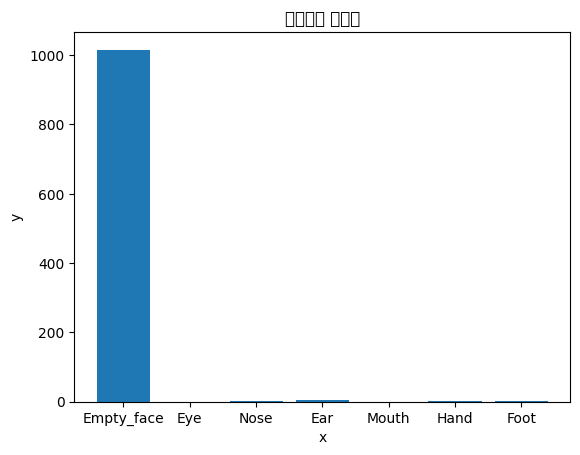

In [2]:
import matplotlib.pyplot as plt

# 주어진 딕셔너리
part=['Empty_face',"Eye","Nose","Ear","Mouth","Hand","Foot"]
data={0: 1016, 1: 0, 2: 1, 3: 4, 4: 0, 5: 1, 6: 1}
data2={}
for i in range(7):
    data2[part[i]]=list(data.values())[i]
# {0: 1139, 1: 5, 2: 3, 3: 47, 4: 5, 5: 5, 6: 2}
# 딕셔너리의 key와 value를 각각 리스트로 추출
x = list(data2.keys())
y = list(data2.values())

# 그래프 생성
plt.bar(x, y)

# x축과 y축에 라벨 추가
plt.xlabel('x')
plt.ylabel('y')

# 그래프 제목 추가
plt.title('딕셔너리 그래프')

# 그래프 표시
plt.show()


In [ ]:
shapely_values

In [6]:
import os
count = dict()
count['m'] = dict()
count['w'] = dict()
for i in range(7,14):
    count['m'][str(i)]= 0
    count['w'][str(i)]= 0

img_path = os.listdir('/local_datasets/ai_hub/ai_hub_sketch_drawer/01/train/m')
for img in img_path:
    age = img.split('_')[1]
    count['m'][age]+=1
img_path = os.listdir('/local_datasets/ai_hub/ai_hub_sketch_drawer/01/train/w')
for img in img_path:
    age = img.split('_')[1]
    count['w'][age]+=1


In [7]:
count

{'m': {'7': 119,
  '8': 1338,
  '9': 1569,
  '10': 2106,
  '11': 2282,
  '12': 2292,
  '13': 2026},
 'w': {'7': 112,
  '8': 927,
  '9': 926,
  '10': 1547,
  '11': 2113,
  '12': 2633,
  '13': 2410}}

In [8]:
import os
count = dict()
count['m'] = dict()
count['w'] = dict()
for i in range(7,14):
    count['m'][str(i)]= 0
    count['w'][str(i)]= 0

img_path = os.listdir('/local_datasets/ai_hub/ai_hub_sketch_drawer/01/train/m')
for img in img_path:
    age = img.split('_')[1]
    count['m'][age]+=1
img_path = os.listdir('/local_datasets/ai_hub/ai_hub_sketch_drawer/01/train/w')
for img in img_path:
    age = img.split('_')[1]
    count['w'][age]+=1

In [9]:
count

{'m': {'7': 119,
  '8': 1338,
  '9': 1569,
  '10': 2106,
  '11': 2282,
  '12': 2292,
  '13': 2026},
 'w': {'7': 112,
  '8': 927,
  '9': 926,
  '10': 1547,
  '11': 2113,
  '12': 2633,
  '13': 2410}}

In [14]:
import os
count = dict()
count['m'] = dict()
count['w'] = dict()
for i in range(7,14):
    count['m'][str(i)]= 0
    count['w'][str(i)]= 0

img_path = os.listdir('/local_datasets/ai_hub/ai_hub_sketch_age/01/train/1')
for img in img_path:
    age = img.split('_')[1]
    count['m'][age]+=1
img_path = os.listdir('/local_datasets/ai_hub/ai_hub_sketch_drawer/01/val/w')
for img in img_path:
    age = img.split('_')[1]
    count['w'][age]+=1

In [15]:
count

{'m': {'7': 0, '8': 0, '9': 0, '10': 3653, '11': 0, '12': 0, '13': 0},
 'w': {'7': 14,
  '8': 124,
  '9': 107,
  '10': 212,
  '11': 258,
  '12': 330,
  '13': 287}}

In [3]:
img_path = os.listdir('/local_datasets/ai_hub/count/01/train/m')
count=dict()
count['m'] = 0
count['w'] = 0
for img in img_path:
    sex = img.split('_')[2]
    count[sex]+=1


In [4]:
count

{'m': 11732, 'w': 10668}

In [8]:
from PIL import Image
image=Image.open('./shapley/TD/B-1-o3.jpg')
# image = image.convert("L")#! Convert grayscale
image = image.point(lambda p: p > 240 and 255)